# Import

In [1]:
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import numpy as np
import random
import seaborn as sns
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.models as models
from torch.backends import cudnn
from torch.cuda.amp import autocast, GradScaler
from sklearn.model_selection import train_test_split
import time
from torchvision.models import VGG16_BN_Weights

In [2]:
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")
print("Number of GPUs:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device() if torch.cuda.is_available() else "N/A")

CUDA available: True
GPU name: NVIDIA GeForce RTX 3050 6GB Laptop GPU
Number of GPUs: 1
Current device: 0


# Load

In [3]:
BASE_PATH = 'crowd data/train/images'
data = []

if os.path.exists(BASE_PATH):
    image_files = [f for f in os.listdir(BASE_PATH) if f.endswith('.jpg')]

    for file_name in image_files:
        full_path = os.path.join(BASE_PATH, file_name)
        data.append({
            'file_name': file_name,
            'full_path': full_path
        })
else:
    print(f"Direktori tidak ditemukan: {BASE_PATH}")

df_images = pd.DataFrame(data)

In [4]:
IMG_DIR = 'crowd data/train/images'
LBL_DIR = 'crowd data/train/labels'

df = pd.DataFrame([
    {'file_name': f, 'full_path': os.path.join(IMG_DIR, f)}
    for f in os.listdir(IMG_DIR) if f.endswith('.jpg')
])

def load_label_points(fname):
    path = os.path.join(LBL_DIR, fname.replace('.jpg', '.json'))
    if not os.path.exists(path): 
        return 0, []
    with open(path) as f:
        data = json.load(f)
    return data['human_num'], data['points']

def draw_points(path, pts):
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    for p in pts: cv2.circle(img, (int(p['x']), int(p['y'])), 4, (255,0,0), -1)
    return img

df[['human_num', 'points']] = df['file_name'].apply(lambda x: pd.Series(load_label_points(x)))
df['annotated_image'] = df.apply(lambda r: draw_points(r.full_path, r.points), axis=1)

# EDA

### Overview

In [5]:
df.head()

file_name                         full_path  human_num  \
0     1.jpg     crowd data/train/images\1.jpg         12   
1    10.jpg    crowd data/train/images\10.jpg          9   
2   100.jpg   crowd data/train/images\100.jpg         17   
3  1000.jpg  crowd data/train/images\1000.jpg         29   
4  1001.jpg  crowd data/train/images\1001.jpg         22   

                                              points  \
0  [{'x': 199.0, 'y': 448.0}, {'x': 69.5, 'y': 45...   
1  [{'x': 220.0, 'y': 327.5}, {'x': 125.0, 'y': 3...   
2  [{'x': 732.0, 'y': 12.0}, {'x': 728.5, 'y': 68...   
3  [{'x': 357.55946014769546, 'y': 676.5204991087...   
4  [{'x': 195.5, 'y': 577.0}, {'x': 109.0, 'y': 5...   

                                     annotated_image  
0  [[[55, 6, 0], [56, 7, 0], [164, 115, 100], [25...  
1  [[[155, 145, 118], [155, 145, 118], [170, 162,...  
2  [[[99, 113, 140], [99, 113, 140], [99, 113, 14...  
3  [[[66, 61, 57], [60, 55, 51], [59, 56, 51], [6...  
4  [[[182, 207, 203], [179, 204, 200], [168, 194,...

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file_name        1100 non-null   object
 1   full_path        1100 non-null   object
 2   human_num        1100 non-null   int64 
 3   points           1100 non-null   object
 4   annotated_image  1100 non-null   object
dtypes: int64(1), object(4)
memory usage: 43.1+ KB


In [7]:
df.isnull().sum()

file_name          0
full_path          0
human_num          0
points             0
annotated_image    0
dtype: int64

In [8]:
df[df['points'].apply(lambda p: len(p) == 0)]

Empty DataFrame
Columns: [file_name, full_path, human_num, points, annotated_image]
Index: []

In [9]:
print(df['file_name'].duplicated().sum())
print(df['full_path'].duplicated().sum())

0
0


### Sample Data

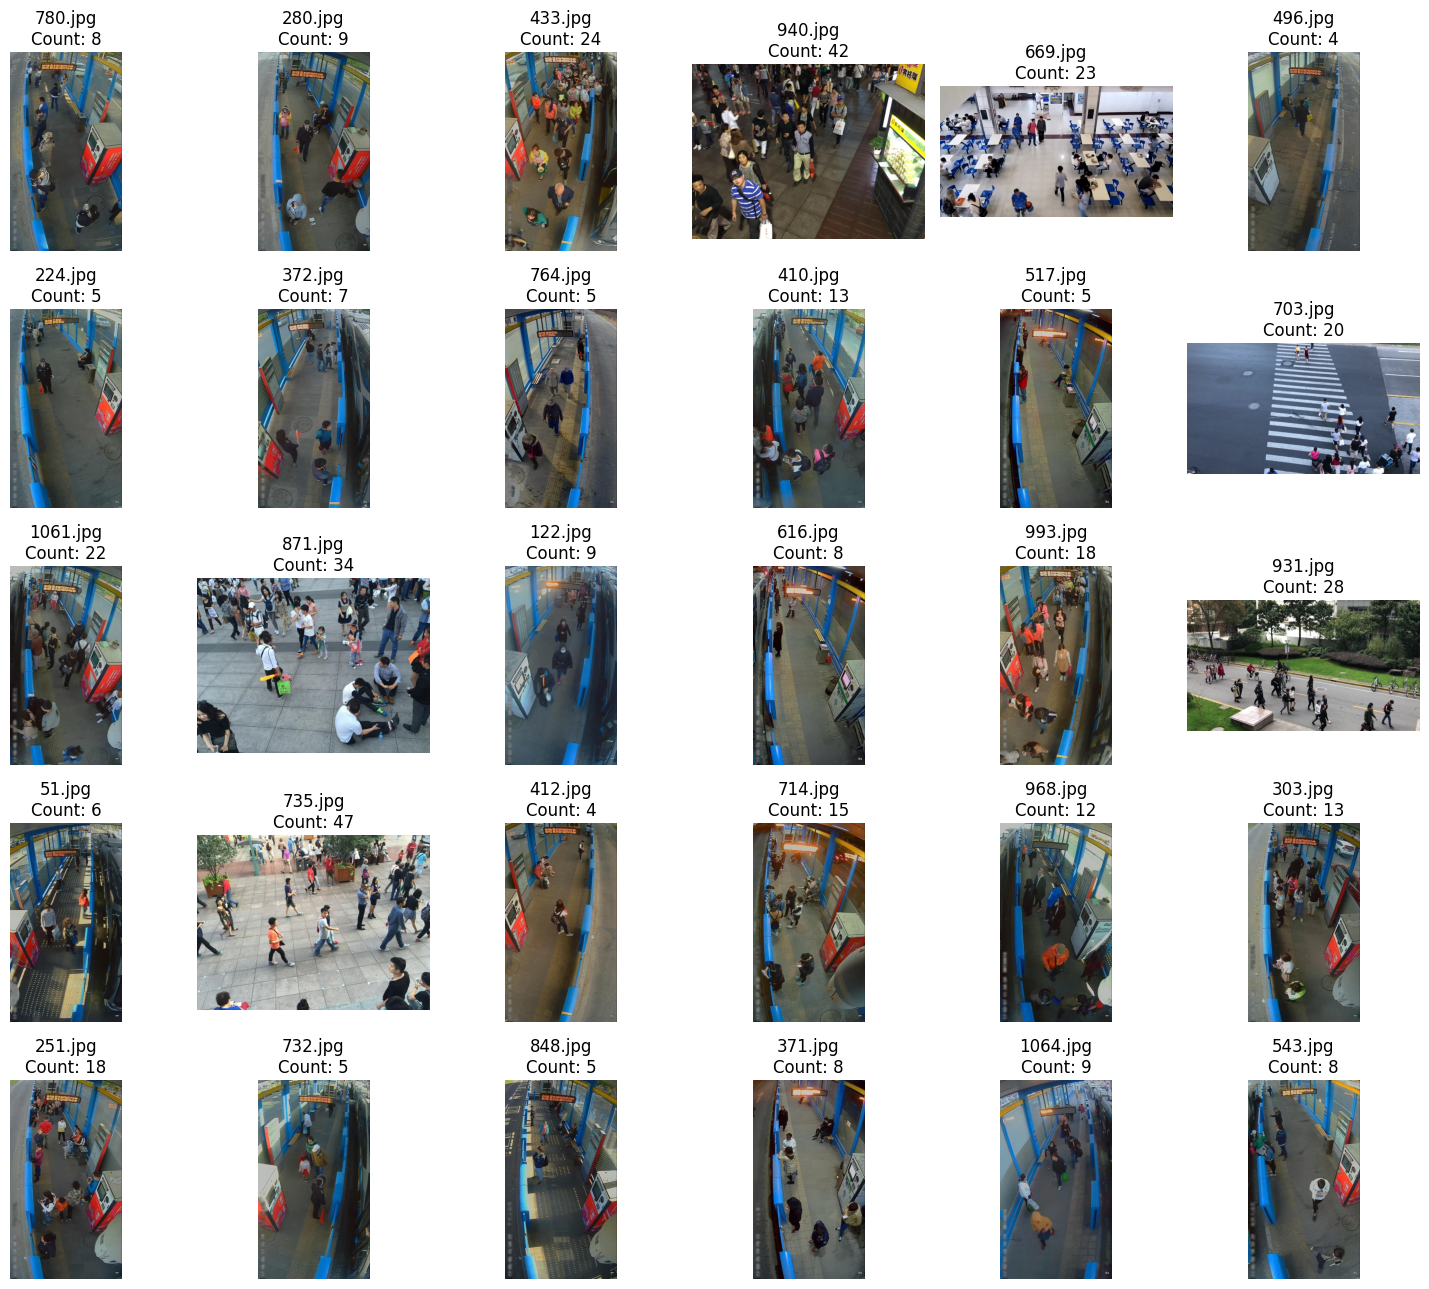

In [10]:
samples = df.sample(30)

plt.figure(figsize=(15, 13))

for i, (_, row) in enumerate(samples.iterrows(), 1):
    img = cv2.imread(row.full_path)
    if img is None:
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(5, 6, i)
    plt.imshow(img)
    plt.title(f"{row.file_name}\nCount: {row.human_num}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [11]:
def show_image(full_path, title="Gambar"):
    """Menampilkan gambar tanpa anotasi."""
    img = cv2.imread(full_path)
    if img is None:
        print(f"Gagal memuat {full_path}")
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(5, 4))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

def show_labeled_image(row, axis='off', size=(8,6)):
    """
    Tampilkan gambar dengan titik koordinat (points).
    Bisa menerima dataframe row atau dict hasil resize.
    """
    img = row.get('annotated_image', None)
    if img is None and 'full_path' in row:
        img = cv2.cvtColor(cv2.imread(row['full_path']), cv2.COLOR_BGR2RGB)

    plt.figure(figsize=size)
    plt.imshow(img)
    for p in row['points']:
        plt.scatter(p['x'], p['y'], c='r', s=15)
    plt.title(f"{row['file_name']} – Jumlah: {row.get('human_num', len(row['points']))}")
    plt.axis(axis)
    plt.show()


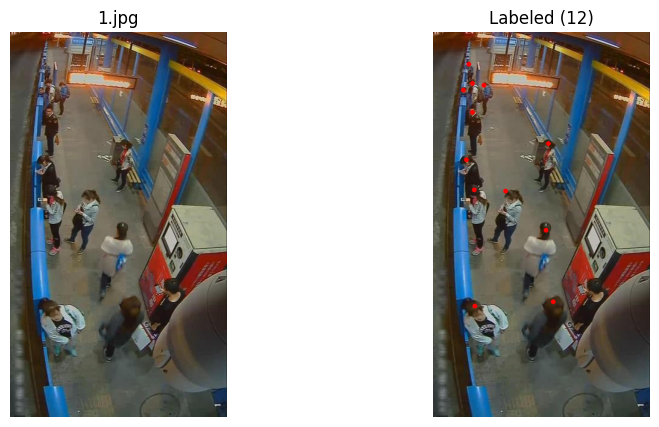

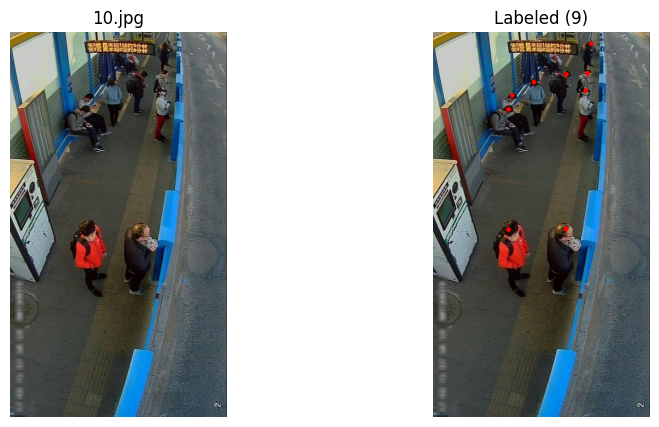

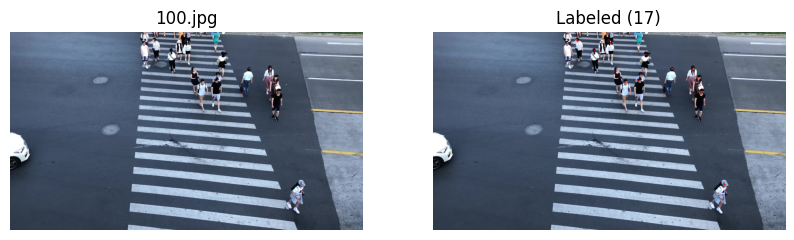

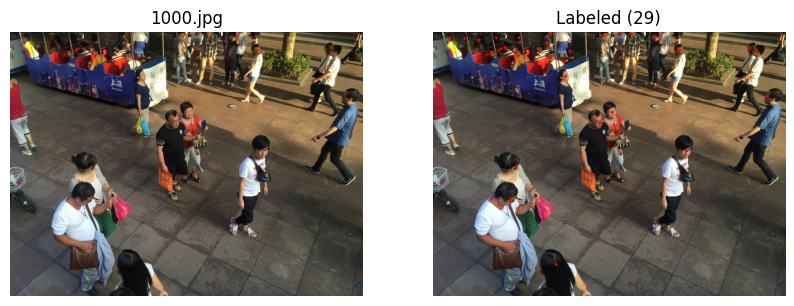

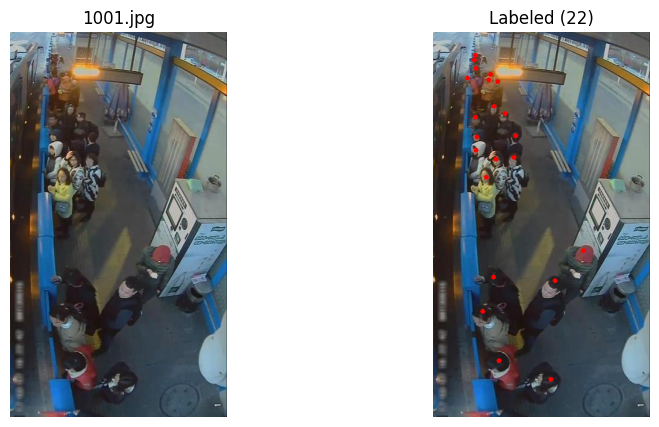

In [12]:
for i in range(min(5, len(df))):
    r = df.iloc[i]
    ori = cv2.cvtColor(cv2.imread(r.full_path), cv2.COLOR_BGR2RGB)
    lab = r.annotated_image if r.annotated_image is not None else ori
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(ori); ax[0].set_title(r.file_name); ax[0].axis('off')
    ax[1].imshow(lab); ax[1].set_title(f"Labeled ({r.human_num})"); ax[1].axis('off')
    plt.show()

`di 1.jpg ada 1 orang yang tidak terlabel, ada kemungkinan terdapat kesalahan di data lain`

### Analisis Konsistensi Label

In [13]:
df['n_points'] = df['points'].apply(len)
df['label_mismatch'] = df['human_num'] != df['n_points']
print(df['label_mismatch'].sum(), "file dengan mismatch label")

0 file dengan mismatch label


### Distribusi titik manusia

count    1100.000000
mean       17.891818
std        14.160272
min         1.000000
25%         7.000000
50%        13.000000
75%        25.000000
max        60.000000
Name: human_num, dtype: float64


<Axes: >

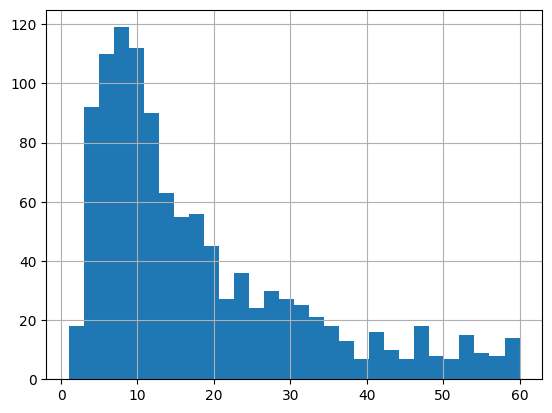

In [14]:
print(df['human_num'].describe())
df['human_num'].hist(bins=30)

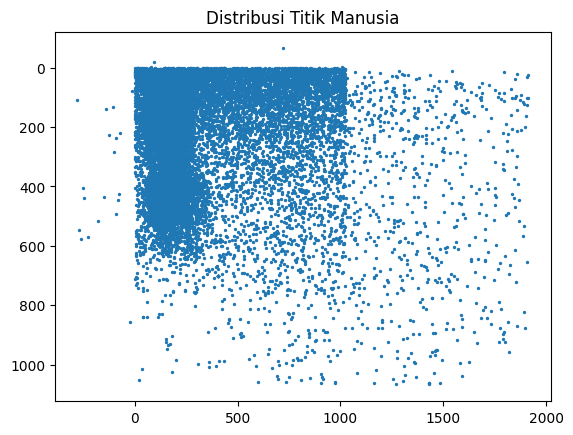

In [15]:
all_points = np.concatenate([[(p['x'], p['y']) for p in pts] for pts in df['points'] if pts])
plt.scatter(*zip(*all_points), s=2)
plt.gca().invert_yaxis()
plt.title('Distribusi Titik Manusia')
plt.show()

Dari plot terlihat bahwa terdapat beberapa titik dengan koordinat negatif atau berada di luar frame gambar. Hal ini menunjukkan bahwa sebagian data memiliki anotasi yang tidak valid dan mungkin perlu difilter sebelum digunakan untuk proses modeling.

In [16]:
out_of_frame = []

for i, row in df.iterrows():
    img = cv2.imread(row.full_path)
    if img is None:
        continue
    h, w = img.shape[:2]

    for p in row.points:
        if p['x'] < 0 or p['y'] < 0 or p['x'] > w or p['y'] > h:
            out_of_frame.append(row.file_name)
            break

print("Jumlah file dengan titik keluar frame:", len(set(out_of_frame)))
print(list(set(out_of_frame)))

Jumlah file dengan titik keluar frame: 37
['747.jpg', '111.jpg', '550.jpg', '274.jpg', '866.jpg', '549.jpg', '1087.jpg', '639.jpg', '1037.jpg', '664.jpg', '354.jpg', '1023.jpg', '568.jpg', '949.jpg', '449.jpg', '925.jpg', '466.jpg', '839.jpg', '500.jpg', '1091.jpg', '685.jpg', '75.jpg', '254.jpg', '886.jpg', '521.jpg', '330.jpg', '991.jpg', '218.jpg', '880.jpg', '1049.jpg', '592.jpg', '695.jpg', '467.jpg', '871.jpg', '391.jpg', '693.jpg', '83.jpg']


Dari hasil analisis, ditemukan 37 titik anotasi yang berada di luar batas gambar (baik koordinat negatif maupun melebihi ukuran frame). Hal ini kemungkinan disebabkan oleh kesalahan anotasi manual dan tidak berdampak besar terhadap distribusi keseluruhan

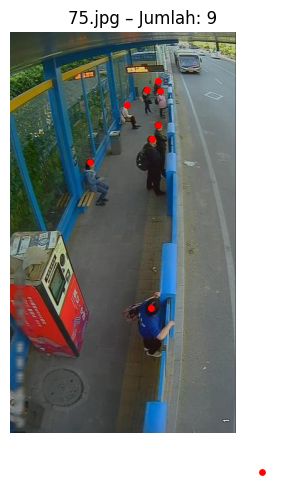

In [17]:
row = df.loc[df['file_name'] == '75.jpg']
show_labeled_image(row.iloc[0])

nah disini terlihat kesalahannya waktu dilakukan visualisasi terhadap salah satu image, label bernilai 9, tetapi titik merah yang berada di dalam frame hanya 8. Ini bisa diatasi dengan beberapa cara, misalnya dengan menghapus titik yang berada diluar frame dan mengurangi labelnya agar sesuai dengan jumlah yang memang terdeteksi, yang kedua adalah dengan menghapus data yang eror.

### Hitung Outframe Dots

In [18]:
out_stats = []

for _, row in df.iterrows():
    img = cv2.imread(row.full_path)
    if img is None:
        continue
    h, w = img.shape[:2]

    invalid_points = [p for p in row.points if p['x'] < 0 or p['y'] < 0 or p['x'] > w or p['y'] > h]
    if invalid_points:
        out_stats.append({
            'file_name': row.file_name,
            'human_num': row.human_num,
            'invalid_points': len(invalid_points),
            'valid_points': len(row.points) - len(invalid_points),
            'adjusted_human_num': row.human_num - len(invalid_points)
        })

df_out_stats = pd.DataFrame(out_stats)
print(f"Total file dengan titik keluar frame: {len(df_out_stats)}")
df_out_stats.head()


Total file dengan titik keluar frame: 37


file_name  human_num  invalid_points  valid_points  adjusted_human_num
0  1023.jpg         41               1            40                  40
1  1037.jpg          3               1             2                   2
2  1049.jpg         58               2            56                  56
3  1087.jpg         33               1            32                  32
4  1091.jpg         15               1            14                  14

In [19]:
df_out_stats.describe()

human_num  invalid_points  valid_points  adjusted_human_num
count  37.000000       37.000000     37.000000           37.000000
mean   31.837838        1.270270     30.567568           30.567568
std    17.140779        0.651863     17.043312           17.043312
min     3.000000        1.000000      2.000000            2.000000
25%    17.000000        1.000000     15.000000           15.000000
50%    34.000000        1.000000     33.000000           33.000000
75%    47.000000        1.000000     46.000000           46.000000
max    60.000000        4.000000     59.000000           59.000000

In [20]:
summary = (
    df_out_stats['invalid_points']
    .value_counts()
    .sort_index()
)

print("Distribusi Jumlah Titik Invalid per Gambar:\n")
for k, v in summary.items():
    print(f"- {k} titik invalid → {v} file")

print(f"\nTotal file dengan titik keluar frame: {len(df_out_stats)}")
print(f"Total titik invalid di seluruh dataset: {df_out_stats['invalid_points'].sum()}")

Distribusi Jumlah Titik Invalid per Gambar:

- 1 titik invalid → 30 file
- 2 titik invalid → 5 file
- 3 titik invalid → 1 file
- 4 titik invalid → 1 file

Total file dengan titik keluar frame: 37
Total titik invalid di seluruh dataset: 47


### Image Resolution

In [21]:
df['shape'] = df['full_path'].apply(lambda p: cv2.imread(p).shape[:2] if os.path.exists(p) else (0,0))
df['shape'].value_counts().head(9)

shape
(640, 360)      861
(768, 1024)     162
(1080, 1920)     63
(720, 1280)      10
(400, 400)        1
(279, 400)        1
(450, 299)        1
(478, 359)        1
Name: count, dtype: int64

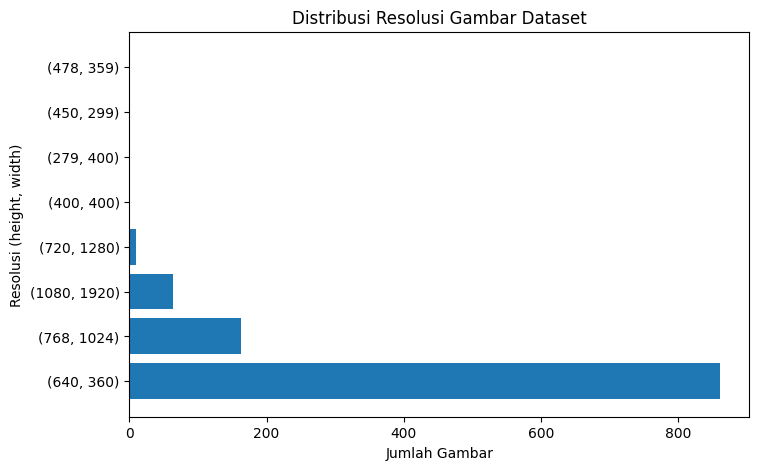

In [22]:
df['height'], df['width'] = zip(*df['shape'])

shape_counts = df['shape'].value_counts().reset_index()
shape_counts.columns = ['(height, width)', 'count']

plt.figure(figsize=(8,5))
plt.barh(shape_counts['(height, width)'].astype(str), shape_counts['count'])
plt.xlabel('Jumlah Gambar')
plt.ylabel('Resolusi (height, width)')
plt.title('Distribusi Resolusi Gambar Dataset')
plt.show()

### Distribusi 'human_num' berdasarkan ukuran gambar 'shape'

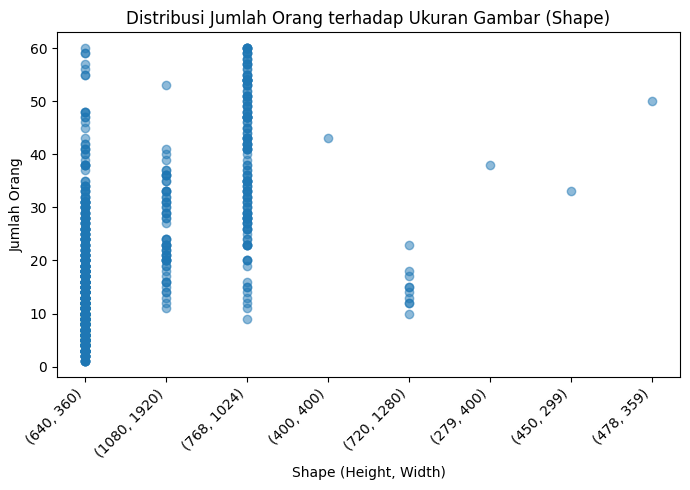

In [23]:
plt.figure(figsize=(7,5))
plt.scatter(df['shape'].astype(str), df['human_num'], alpha=0.5)
plt.title('Distribusi Jumlah Orang terhadap Ukuran Gambar (Shape)')
plt.xlabel('Shape (Height, Width)')
plt.ylabel('Jumlah Orang')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Temuan
| Temuan                                      | Dampak                              | Tindakan Disarankan                  |
| ------------------------------------------- | ----------------------------------- | ------------------------------------ |
| Label mismatch (`human_num` ≠ jumlah titik) | Model bisa belajar dari label salah | Koreksi otomatis atau relabel        |
| Titik di luar frame (37 file)               | Distorsi data, error pada training  | Hapus titik invalid                  |
| Ukuran gambar tidak seragam                 | Model sulit konvergen               | Resize semua gambar sebelum training |
| Distribusi tidak seimbang                   | Model bias ke kelas “sedikit orang” | Augmentasi atau penyeimbangan data   |
| Posisi titik tidak merata                   | Bias posisi                         | Gunakan augmentasi (flip/crop)       |


# Data Preparation

## Cleaning

Kondisi yang harus dipenuhi saat cleaning:
1. atasi invalid points
2. resize
3. human_num sesuai n_points

In [24]:
df.head(3)

file_name                        full_path  human_num  \
0     1.jpg    crowd data/train/images\1.jpg         12   
1    10.jpg   crowd data/train/images\10.jpg          9   
2   100.jpg  crowd data/train/images\100.jpg         17   

                                              points  \
0  [{'x': 199.0, 'y': 448.0}, {'x': 69.5, 'y': 45...   
1  [{'x': 220.0, 'y': 327.5}, {'x': 125.0, 'y': 3...   
2  [{'x': 732.0, 'y': 12.0}, {'x': 728.5, 'y': 68...   

                                     annotated_image  n_points  \
0  [[[55, 6, 0], [56, 7, 0], [164, 115, 100], [25...        12   
1  [[[155, 145, 118], [155, 145, 118], [170, 162,...         9   
2  [[[99, 113, 140], [99, 113, 140], [99, 113, 14...        17   

   label_mismatch         shape  height  width  
0           False    (640, 360)     640    360  
1           False    (640, 360)     640    360  
2           False  (1080, 1920)    1080   1920

### Labeling ulang dan hapus invalid points

In [25]:
df_clean = df.copy()

invalid_points_info = []

for i, row in df_clean.iterrows():
    img = cv2.imread(row.full_path)
    if img is None:
        continue
    h, w = img.shape[:2]

    valid_points = [p for p in row.points if 0 <= p['x'] <= w and 0 <= p['y'] <= h]

    df_clean.at[i, 'points'] = valid_points
    df_clean.at[i, 'human_num'] = len(valid_points)

    dropped = len(row.points) - len(valid_points)
    if dropped > 0:
        invalid_points_info.append({
            'file_name': row.file_name,
            'invalid_points': dropped
        })

df_invalid_points = pd.DataFrame(invalid_points_info)
print(f"Total file yang dibersihkan: {len(df_invalid_points)}")
print(f"Total titik invalid dihapus: {df_invalid_points['invalid_points'].sum()}")

Total file yang dibersihkan: 37
Total titik invalid dihapus: 47


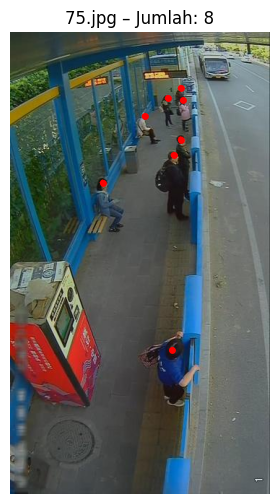

In [26]:
row = df_clean[df_clean['file_name'] == '75.jpg'].iloc[0]
show_labeled_image(row, axis='off')

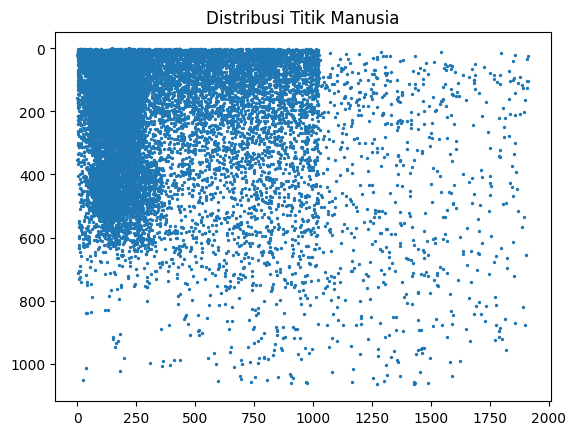

In [27]:
all_points = np.concatenate([[(p['x'], p['y']) for p in pts] for pts in df_clean['points'] if pts])
plt.scatter(*zip(*all_points), s=2)
plt.gca().invert_yaxis()
plt.title('Distribusi Titik Manusia')
plt.show()

dari gambar diatas, jumlahnya sudah sesuai dengan apa yang ada di gambar dan dari plot tidak ada yang outframe

In [28]:
def resize_with_padding(img, points, target_size=(360, 640)):
    """Resize gambar dengan padding sambil menyesuaikan koordinat titik."""
    h, w = img.shape[:2]
    th, tw = target_size

    # Rasio resize proporsional
    scale = min(tw / w, th / h)
    nh, nw = int(h * scale), int(w * scale)

    # Resize gambar
    resized = cv2.resize(img, (nw, nh), interpolation=cv2.INTER_AREA)

    # Hitung padding
    top = (th - nh) // 2
    bottom = th - nh - top
    left = (tw - nw) // 2
    right = tw - nw - left

    # Tambahkan padding (hitam)
    padded = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(0, 0, 0))

    # Sesuaikan koordinat titik
    new_points = []
    for p in points:
        new_x = p['x'] * scale + left
        new_y = p['y'] * scale + top
        new_points.append({'x': new_x, 'y': new_y})

    return padded, new_points

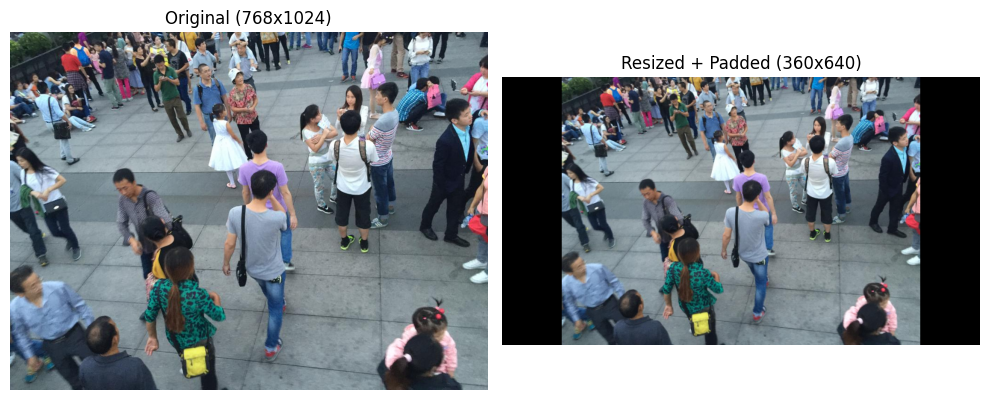

In [29]:
row = df_clean[df_clean['file_name'] == '820.jpg'].iloc[0]

img = cv2.imread(row.full_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

resized_img, new_points = resize_with_padding(img, row.points, target_size=(360, 640))

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(img)
axes[0].set_title(f"Original ({img.shape[0]}x{img.shape[1]})")
axes[0].axis("off")

axes[1].imshow(resized_img)
axes[1].set_title(f"Resized + Padded ({resized_img.shape[0]}x{resized_img.shape[1]})")
axes[1].axis("off")
plt.tight_layout()
plt.show()

Koordinat baru untuk 820.jpg (total 51 titik):
(105.59, 254.00)
(248.77, 232.38)
(228.90, 198.48)
(196.18, 155.24)
(500.66, 323.55)
(507.09, 292.57)
(332.93, 158.16)
(330.01, 112.57)
(386.70, 85.11)
(420.01, 92.12)
(421.76, 66.99)
(449.81, 67.57)
(540.98, 83.94)
(556.76, 38.35)
(505.92, 48.87)
(494.23, 54.72)
(497.15, 3.29)
(456.24, 7.38)
(311.89, 16.14)
(309.55, 1.53)
(310.72, 48.87)
(293.77, 80.43)
(279.16, 40.69)
(272.74, 14.39)
(240.59, 16.14)
(231.24, 31.92)
(112.02, 55.89)
(216.73, 16.29)
(215.56, 20.38)
(211.76, 20.09)
(198.32, 8.40)
(191.02, 3.14)
(180.79, 2.85)
(182.54, 10.45)
(175.53, 13.95)
(166.47, 17.17)
(163.26, 20.38)
(146.31, 10.15)
(142.80, 13.95)
(135.79, 17.17)
(233.39, 9.86)
(122.93, 43.17)
(142.51, 59.25)
(105.69, 48.14)
(96.34, 55.15)
(91.08, 55.15)
(127.61, 44.34)
(171.42, 307.87)
(228.57, 10.06)
(244.32, 6.55)
(185.83, 7.45)


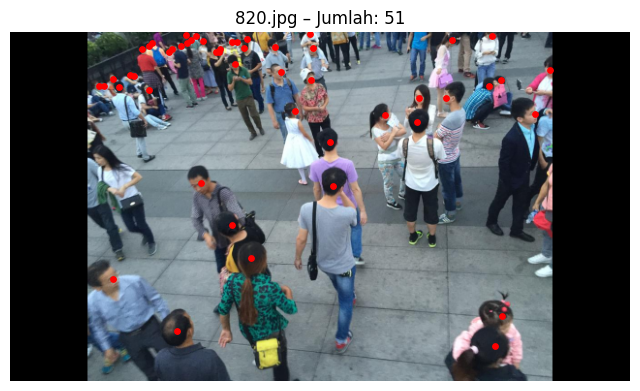

In [30]:
print(f"Koordinat baru untuk {row.file_name} (total {len(new_points)} titik):")
for p in new_points:
    print(f"({p['x']:.2f}, {p['y']:.2f})")

show_labeled_image({
    'file_name': row.file_name,
    'annotated_image': resized_img,
    'points': new_points,
    'human_num': len(new_points)
})

In [31]:
def apply_resize_padding(df, target_size=(360, 640)):
    """
    Terapkan resize_with_padding untuk semua data di df_clean.
    Mengembalikan dataframe baru df_resized.
    """
    df_resized = df.copy()
    resized_images = []
    updated_points = []
    new_shapes = []

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Resizing + Padding"):
        img = cv2.imread(row.full_path)
        if img is None:
            resized_images.append(None)
            updated_points.append([])
            new_shapes.append((0, 0))
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        resized_img, new_points = resize_with_padding(img, row.points, target_size=target_size)

        resized_images.append(resized_img)
        updated_points.append(new_points)
        new_shapes.append(resized_img.shape[:2])

    df_resized['annotated_image'] = resized_images
    df_resized['points'] = updated_points
    df_resized['shape'] = new_shapes
    df_resized['height'] = [s[0] for s in new_shapes]
    df_resized['width'] = [s[1] for s in new_shapes]
    df_resized['human_num'] = df_resized['points'].apply(len)

    return df_resized

In [32]:
df_resized = apply_resize_padding(df_clean, target_size=(360, 640))

Resizing + Padding: 100%|██████████| 1100/1100 [00:05<00:00, 213.09it/s]


In [33]:
df_resized.head(3)

file_name                        full_path  human_num  \
0     1.jpg    crowd data/train/images\1.jpg         12   
1    10.jpg   crowd data/train/images\10.jpg          9   
2   100.jpg  crowd data/train/images\100.jpg         17   

                                              points  \
0  [{'x': 330.9375, 'y': 252.0}, {'x': 258.09375,...   
1  [{'x': 342.75, 'y': 184.21875}, {'x': 289.3125...   
2  [{'x': 244.0, 'y': 4.0}, {'x': 242.83333333333...   

                                     annotated_image  n_points  \
0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...        12   
1  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...         9   
2  [[[99, 113, 140], [99, 113, 140], [99, 113, 14...        17   

   label_mismatch       shape  height  width  
0           False  (360, 640)     360    640  
1           False  (360, 640)     360    640  
2           False  (360, 640)     360    640

In [34]:
print("Total gambar:", len(df_resized))
print("Ukuran unik:", df_resized['shape'].unique())
print("Total invalid points:", sum(len(p)==0 for p in df_resized['points']))

Total gambar: 1100
Ukuran unik: [(360, 640)]
Total invalid points: 0


In [35]:
def generate_density_map(image_shape, points, sigma, normalize=True):
    """
    Generate density map from points.
    - image_shape: (H, W, C) or (H, W)
    - points: list of {'x':.., 'y':..} already adjusted to image coords
    - sigma: gaussian sigma
    - normalize: scale map so sum == len(points)
    """
    h, w = image_shape[:2]
    density = np.zeros((h, w), dtype=np.float32)

    if len(points) == 0:
        return density

    for p in points:
        x, y = int(round(p['x'])), int(round(p['y']))
        if 0 <= x < w and 0 <= y < h:
            density[y, x] = 1.0

    density = cv2.GaussianBlur(density, ksize=(0, 0), sigmaX=sigma, sigmaY=sigma, borderType=cv2.BORDER_CONSTANT)

    if normalize:
        s = density.sum()
        if s > 0:
            density = density * (len(points) / s)

    return density


In [36]:
df_resized['density_map'] = df_resized.apply(
    lambda r: generate_density_map(r['annotated_image'].shape, r['points'], sigma=5),
    axis=1
)

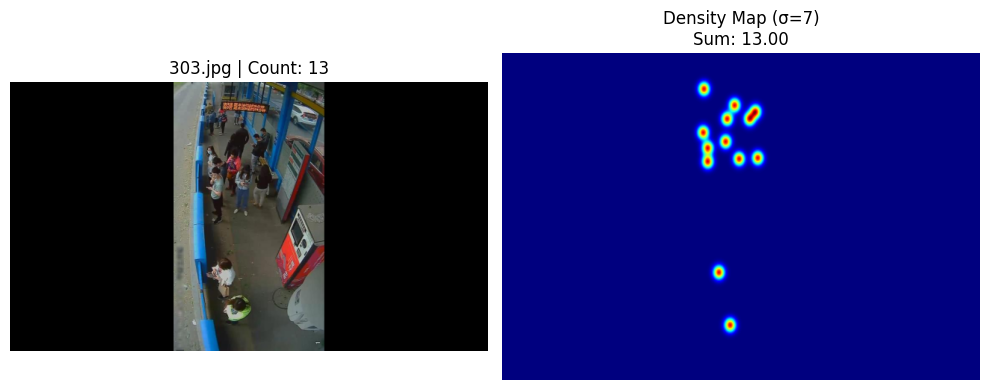

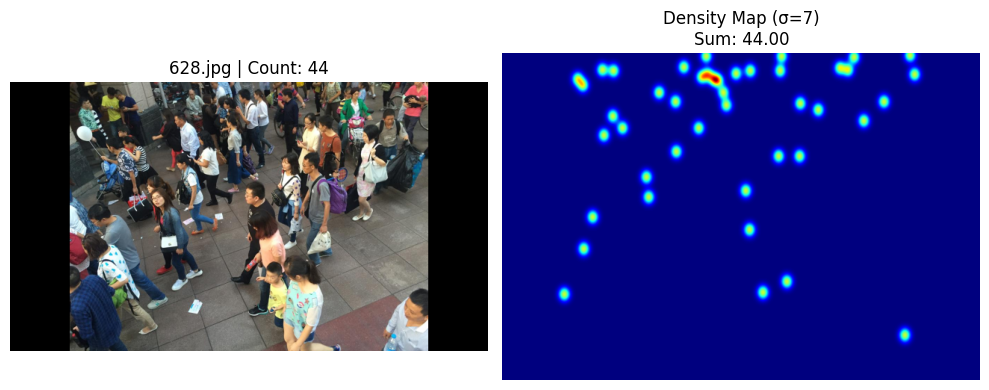

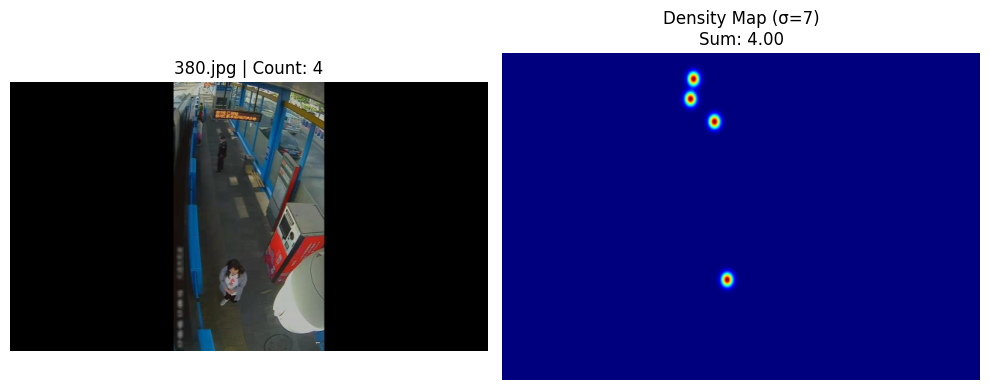

In [37]:
samples = df_resized.sample(3, random_state=42)

for _, r in samples.iterrows():
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].imshow(r['annotated_image'])
    ax[0].set_title(f"{r['file_name']} | Count: {r['human_num']}")
    ax[0].axis('off')

    ax[1].imshow(r['density_map'], cmap='jet', aspect='auto')
    ax[1].set_title(f"Density Map (σ=7)\nSum: {r['density_map'].sum():.2f}")
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

## Dataset pt

In [38]:
def downsample_density_map(density_map, ratio=8):
    h, w = density_map.shape
    new_h, new_w = h // ratio, w // ratio
    downsampled = cv2.resize(density_map, (new_w, new_h), interpolation=cv2.INTER_CUBIC)
    downsampled = downsampled * (ratio * ratio)
    return downsampled

df_resized['density_map_full'] = df_resized.apply(
    lambda r: generate_density_map(r['annotated_image'].shape, r['points'], sigma=5),
    axis=1
)

df_resized['density_map'] = df_resized['density_map_full'].apply(
    lambda dm: downsample_density_map(dm, ratio=8)
)

In [39]:
def preprocess_split(image_dir, label_dir, target_size=(360, 640), sigma=5):
    data = []
    for json_file in os.listdir(label_dir):
        if not json_file.endswith('.json'): continue
        with open(os.path.join(label_dir, json_file), 'r') as f:
            ann = json.load(f)
        img_path = os.path.join(image_dir, ann['img_id'])
        img = cv2.imread(img_path)
        if img is None: continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        resized_img, new_points = resize_with_padding(img, ann['points'], target_size)
        
        density_map_full = generate_density_map(resized_img.shape, new_points, sigma=sigma)
        
        density_map = downsample_density_map(density_map_full, ratio=8)

        data.append({
            'file_name': ann['img_id'],
            'annotated_image': resized_img,
            'points': new_points,
            'human_num': len(new_points),
            'density_map': density_map  # ← Sekarang ukurannya (45, 80)
        })

    return pd.DataFrame(data)

df_test = preprocess_split(
    'crowd data/test/images',
    'crowd data/test/labels',
    target_size=(360,640),
    sigma=5
)

In [40]:
class CrowdDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = row['annotated_image'] / 255.0
        density = row['density_map']

        img_tensor = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)
        density_tensor = torch.tensor(density, dtype=torch.float32).unsqueeze(0)
        return img_tensor, density_tensor

In [41]:
train_dataset = CrowdDataset(df_resized)

# 80% dari test, sisanya untuk evaluasi
df_test_sampled, df_try = train_test_split(df_test, test_size=0.2, random_state=42)
test_dataset = CrowdDataset(df_test_sampled)

In [42]:
train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=0,
    pin_memory=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

Train samples: 1100, Test samples: 320


In [43]:
class CSRNet(nn.Module):
    def __init__(self, load_weights=True):
        super(CSRNet, self).__init__()
        vgg = models.vgg16_bn(pretrained=load_weights)
        self.frontend = nn.Sequential(*list(vgg.features.children())[:33])
        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True)
        )
        self.output_layer = nn.Conv2d(64, 1, 1)
    
    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CSRNet().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

d:\anaconda\envs\nlp_gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda\envs\nlp_gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\FAUZAN\AppData\Local\Temp\ipykernel_16916\4196625565.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None


In [ ]:
import time
import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler

patience = 2
min_delta = 1e-5
best_val_mae = float('inf')
epochs_no_improve = 0
early_stop = False
best_model_path = 'best_crowd_model_5.pth'

epochs = 50
criterion = nn.MSELoss() 

for epoch in range(epochs):
    if early_stop:
        print(f"\nEarly stopping at Epoch {epoch:02d}. Loading best model...")
        model.load_state_dict(torch.load(best_model_path))
        break

    model.train()
    total_mse_loss = 0
    start_time = time.time()

    for imgs, dens in train_loader:
        imgs, dens = imgs.to(device), dens.to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            preds = model(imgs)
            loss = criterion(preds, dens)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_mse_loss += loss.item()

    avg_train_mse = total_mse_loss / len(train_loader)
    
    model.eval()
    val_mse_loss = 0
    val_mae_sum = 0
    
    with torch.no_grad():
        for imgs, dens in test_loader:
            imgs, dens = imgs.to(device), dens.to(device)

            with torch.cuda.amp.autocast():
                preds = model(imgs)
                loss = criterion(preds, dens) # MSE Loss

            val_mse_loss += loss.item()

            pred_counts = torch.sum(preds, dim=(1, 2, 3))
            target_counts = torch.sum(dens, dim=(1, 2, 3))
            
            val_mae_sum += torch.sum(torch.abs(pred_counts - target_counts)).item()
            
    
    avg_val_mse = val_mse_loss / len(test_loader)
    avg_val_mae = val_mae_sum / len(test_dataset)

    print(f"\n[Epoch {epoch+1:02d}/{epochs}] Time: {time.time()-start_time:.1f}s")
    print(f"  Training | MSE: {avg_train_mse:.5f}")
    print(f"Validation | MSE: {avg_val_mse:.5f} | MAE: {avg_val_mae:.2f}")

    if avg_val_mae < best_val_mae - min_delta:
        print(f" Validation MAE improved from {best_val_mae:.2f} to {avg_val_mae:.2f}. Saving model...")
        best_val_mae = avg_val_mae
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
    elif avg_val_mae >= best_val_mae - min_delta:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            early_stop = True

print("\ntraining selesai")

C:\Users\FAUZAN\AppData\Local\Temp\ipykernel_26348\1748300792.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\FAUZAN\AppData\Local\Temp\ipykernel_26348\1748300792.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



[Epoch 01/50] Time: 85.7s
  Training | MSE: 0.00106
Validation | MSE: 0.00087 | MAE: 21.79
 Validation MAE improved from inf to 21.79. Saving model...

[Epoch 02/50] Time: 92.0s
  Training | MSE: 0.00039
Validation | MSE: 0.00033 | MAE: 8.82
 Validation MAE improved from 21.79 to 8.82. Saving model...

[Epoch 03/50] Time: 93.0s
  Training | MSE: 0.00028
Validation | MSE: 0.00031 | MAE: 4.74
 Validation MAE improved from 8.82 to 4.74. Saving model...

[Epoch 04/50] Time: 88.0s
  Training | MSE: 0.00022
Validation | MSE: 0.00030 | MAE: 3.63
 Validation MAE improved from 4.74 to 3.63. Saving model...

[Epoch 05/50] Time: 81.3s
  Training | MSE: 0.00017
Validation | MSE: 0.00030 | MAE: 3.56
 Validation MAE improved from 3.63 to 3.56. Saving model...

[Epoch 06/50] Time: 81.5s
  Training | MSE: 0.00013
Validation | MSE: 0.00029 | MAE: 3.36
 Validation MAE improved from 3.56 to 3.36. Saving model...

[Epoch 07/50] Time: 80.7s
  Training | MSE: 0.00010
Validation | MSE: 0.00028 | MAE: 3.02
 

C:\Users\FAUZAN\AppData\Local\Temp\ipykernel_26348\1748300792.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


# Evaluasi

In [65]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CSRNet().to(device)

model_path = 'best_crowd_model_5.pth' 

state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)
model.eval()
print(f"Sukses load model dari: {model_path}")
print(f"Device: {device}")

d:\anaconda\envs\nlp_gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda\envs\nlp_gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sukses load model dari: best_crowd_model_5.pth
Device: cuda


C:\Users\FAUZAN\AppData\Local\Temp\ipykernel_16916\2607016571.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


### Reconstructing Training Curves from Logs

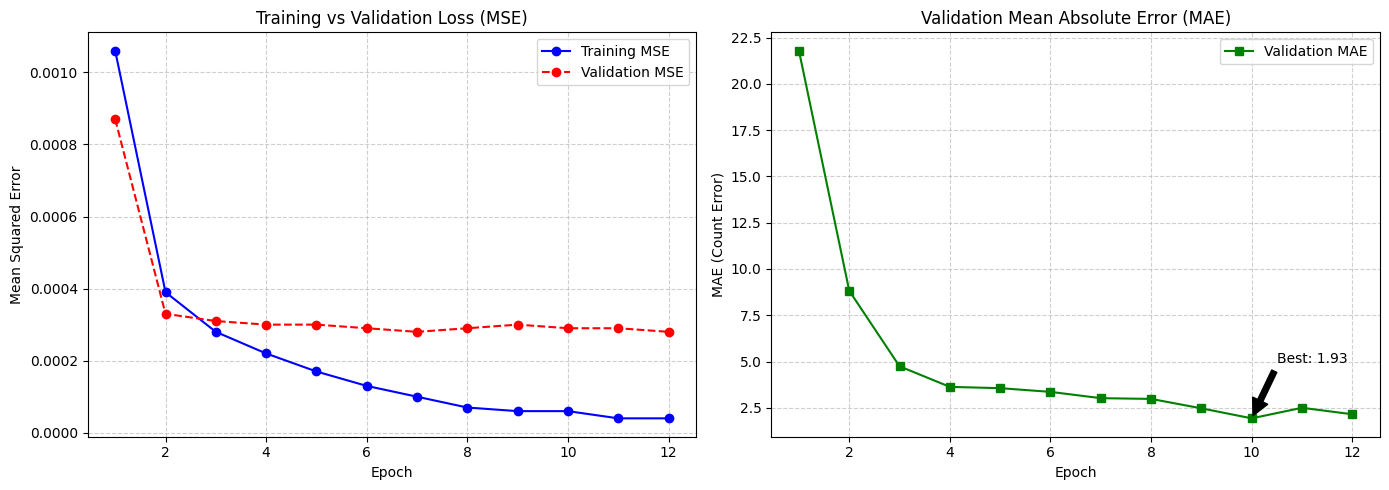

In [66]:
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

train_mse = [0.00106, 0.00039, 0.00028, 0.00022, 0.00017, 
             0.00013, 0.00010, 0.00007, 0.00006, 0.00006, 
             0.00004, 0.00004]

val_mse = [0.00087, 0.00033, 0.00031, 0.00030, 0.00030, 
           0.00029, 0.00028, 0.00029, 0.00030, 0.00029, 
           0.00029, 0.00028]

val_mae = [21.79, 8.82, 4.74, 3.63, 3.56, 
           3.36, 3.02, 2.98, 2.47, 1.93, 
           2.50, 2.15]

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_mse, label='Training MSE', marker='o', linestyle='-', color='blue')
plt.plot(epochs, val_mse, label='Validation MSE', marker='o', linestyle='--', color='red')
plt.title('Training vs Validation Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1, 2, 2)
plt.plot(epochs, val_mae, label='Validation MAE', marker='s', linestyle='-', color='green')

best_epoch = 10
best_mae = 1.93
plt.annotate(f'Best: {best_mae}', xy=(best_epoch, best_mae), xytext=(best_epoch+0.5, best_mae+3),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.title('Validation Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE (Count Error)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [67]:
# lakukan prediksi dengan model yang sudah ditrain
model.eval()

true_counts = []
pred_counts = []
visual_samples = []

with torch.no_grad():
    for imgs, dens in test_loader:
        imgs = imgs.to(device)
        dens = dens.to(device)
        
        preds = model(imgs)
        
        for i in range(len(imgs)):
            tc = torch.sum(dens[i]).item()
            pc = torch.sum(preds[i]).item()
            
            true_counts.append(tc)
            pred_counts.append(pc)
            
            if len(visual_samples) < 3:
                visual_samples.append({
                    'img': imgs[i].permute(1, 2, 0).cpu().numpy(),
                    'gt_map': dens[i].squeeze().cpu().numpy(),
                    'pred_map': preds[i].squeeze().cpu().numpy(),
                    'gt_count': tc,
                    'pred_count': pc
                })

true_counts = np.array(true_counts)
pred_counts = np.array(pred_counts)

In [68]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mae_val = mean_absolute_error(true_counts, pred_counts)
mse_val = mean_squared_error(true_counts, pred_counts)
rmse_val = np.sqrt(mse_val)

df_metrics = pd.DataFrame({
    'Metrik': ['MAE', 'MSE', 'RMSE'],
    'Nilai': [mae_val, mse_val, rmse_val]
})

df_metrics

Metrik      Nilai
0    MAE   1.902883
1    MSE  10.739750
2   RMSE   3.277156

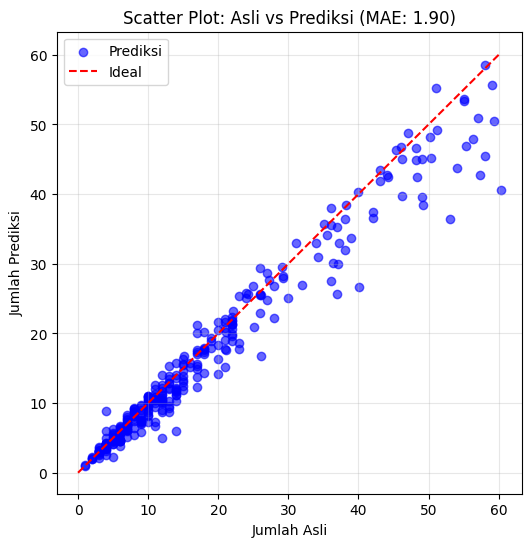

In [69]:
plt.figure(figsize=(6, 6))
plt.scatter(true_counts, pred_counts, alpha=0.6, c='blue', label='Prediksi')

limit = max(true_counts.max(), pred_counts.max())
plt.plot([0, limit], [0, limit], 'r--', label='Ideal')

plt.title(f'Scatter Plot: Asli vs Prediksi (MAE: {df_metrics[df_metrics["Metrik"] == "MAE"]["Nilai"].values[0]:.2f})')
plt.xlabel('Jumlah Asli')
plt.ylabel('Jumlah Prediksi')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

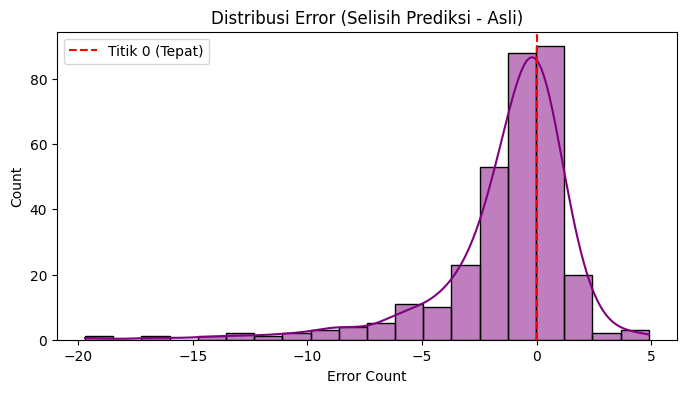

In [70]:
errors = pred_counts - true_counts

plt.figure(figsize=(8, 4))
sns.histplot(errors, kde=True, bins=20, color='purple')
plt.axvline(x=0, color='red', linestyle='--', label='Titik 0 (Tepat)')
plt.title('Distribusi Error (Selisih Prediksi - Asli)')
plt.xlabel('Error Count')
plt.legend()
plt.show()

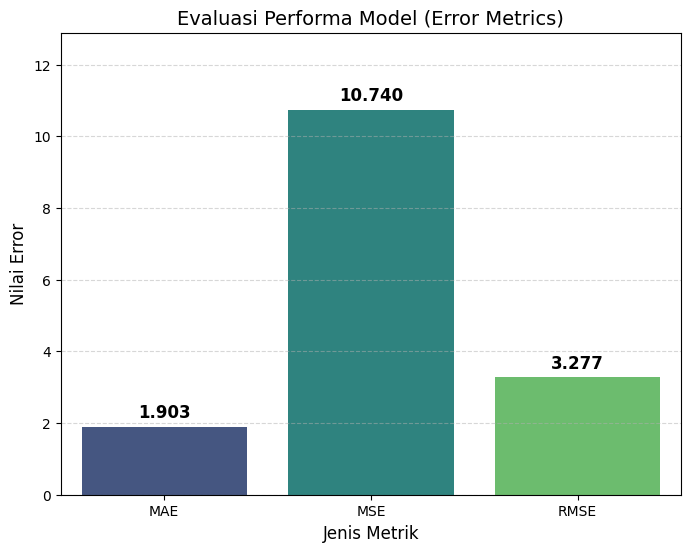

In [71]:
plt.figure(figsize=(8, 6))

ax = sns.barplot(x='Metrik', y='Nilai', hue='Metrik', data=df_metrics, palette='viridis', legend=False)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), textcoords='offset points', fontsize=12, fontweight='bold')

plt.title('Evaluasi Performa Model (Error Metrics)', fontsize=14)
plt.ylabel('Nilai Error', fontsize=12)
plt.xlabel('Jenis Metrik', fontsize=12)
plt.ylim(0, max([mae_val, mse_val, rmse_val]) * 1.2) 
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

### Test Input Output

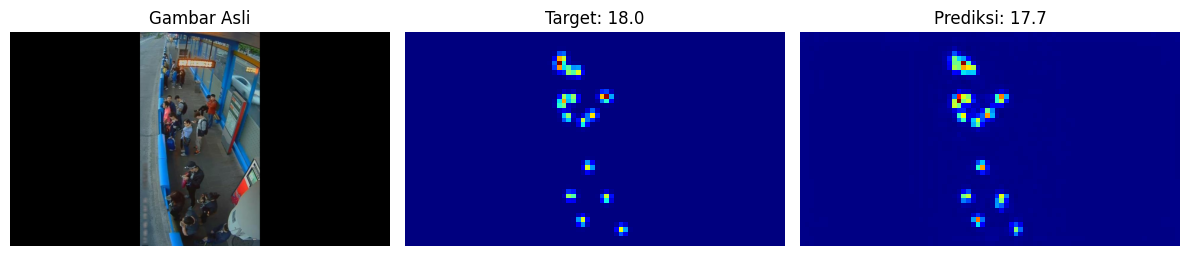

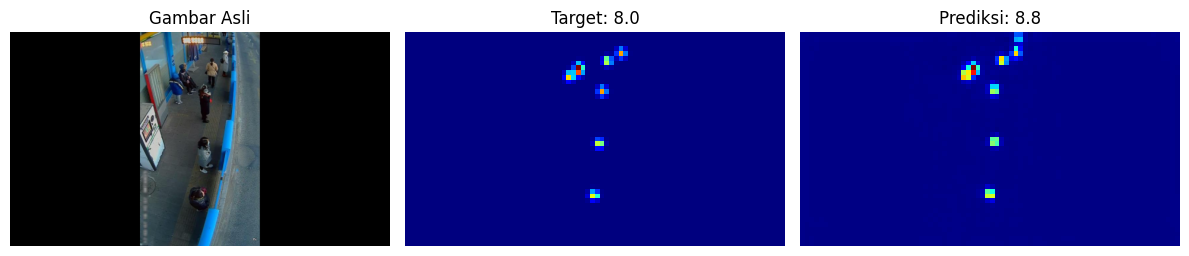

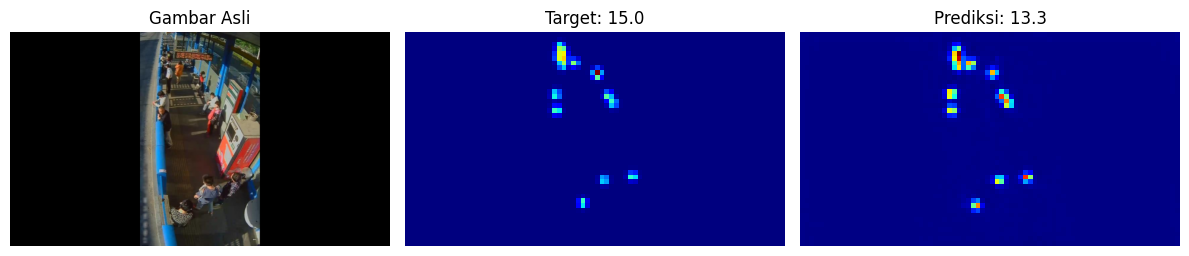

In [72]:
for sample in visual_samples:
    fig, ax = plt.subplots(1, 3, figsize=(12, 3))
    
    ax[0].imshow(sample['img'])
    ax[0].set_title("Gambar Asli")
    ax[0].axis('off')
    
    ax[1].imshow(sample['gt_map'], cmap='jet')
    ax[1].set_title(f"Target: {sample['gt_count']:.1f}")
    ax[1].axis('off')
    
    ax[2].imshow(sample['pred_map'], cmap='jet')
    ax[2].set_title(f"Prediksi: {sample['pred_count']:.1f}")
    ax[2].axis('off')
    
    plt.tight_layout()
    plt.show()

### Percobaan Test Titik

=== PREDIKSI TITIK LOKASI (KOORDINAT) ===


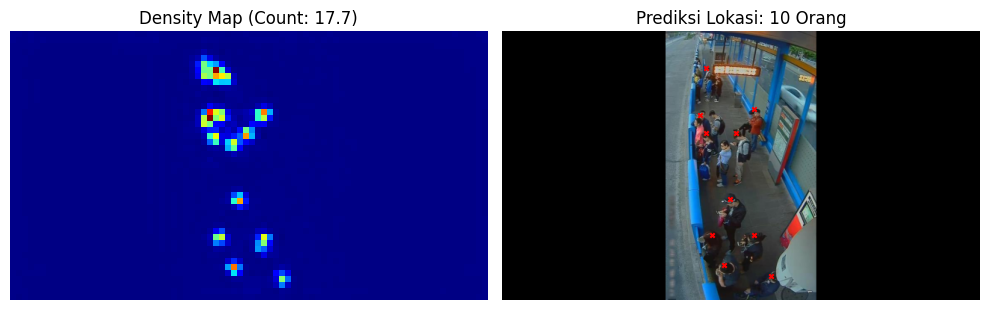

Contoh koordinat (x, y) untuk gambar di atas: [[112 264]
 [ 48 272]
 [312 296]]



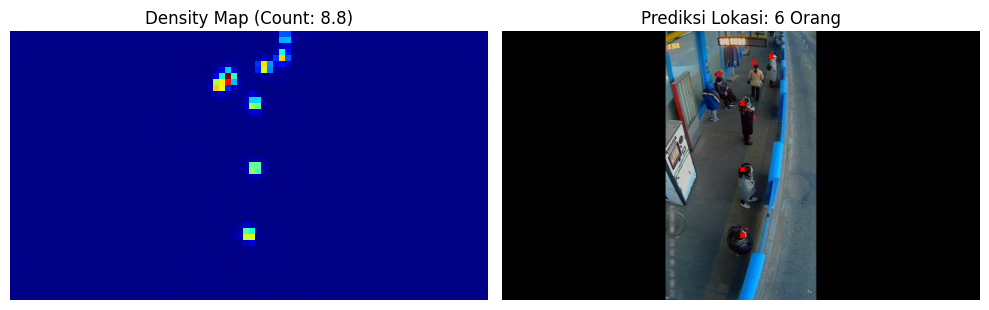

Contoh koordinat (x, y) untuk gambar di atas: [[ 56 288]
 [ 32 360]
 [ 40 336]]



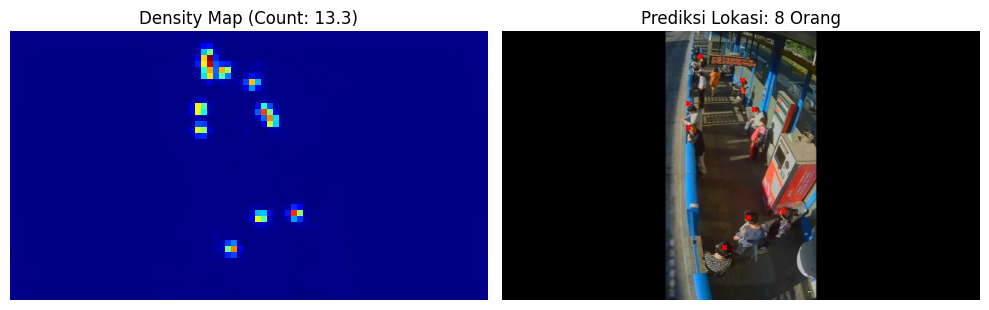

Contoh koordinat (x, y) untuk gambar di atas: [[ 32 264]
 [240 376]
 [104 336]]



In [ ]:
from skimage.feature import peak_local_max
import matplotlib.patches as patches

print("=== PREDIKSI TITIK LOKASI (KOORDINAT) ===")

scale_factor = 8 

for sample in visual_samples:
    dmap = sample['pred_map']
    
    coordinates = peak_local_max(dmap, min_distance=2, threshold_abs=0.02)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    
    ax[0].imshow(dmap, cmap='jet')
    ax[0].set_title(f"Density Map (Count: {sample['pred_count']:.1f})")
    ax[0].axis('off')
    
    img_show = sample['img']
    ax[1].imshow(img_show)
    ax[1].set_title(f"Prediksi Lokasi: {len(coordinates)} Orang")
    ax[1].axis('off')
    
    if len(coordinates) > 0:
        y_coords = coordinates[:, 0] * scale_factor
        x_coords = coordinates[:, 1] * scale_factor
        ax[1].scatter(x_coords, y_coords, c='red', s=10, marker='x', label='Prediksi')
        
    plt.tight_layout()
    plt.show()

    print(f"Contoh koordinat (x, y) untuk gambar di atas: {coordinates[:3] * scale_factor}\n")